In [1]:
import matplotlib.pyplot as plt
from pyteomics import mzml, mzmlb
import numpy as np
import pandas as pd
import h5py

/home/wkumler/miniconda3/envs/mzsql/lib/python3.12/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


# Manually convert the mzML file to an mzMLb file using the Proteowizard GUI
It doesn't seem like msconvert supports mzMLb conversion via command line (yet)

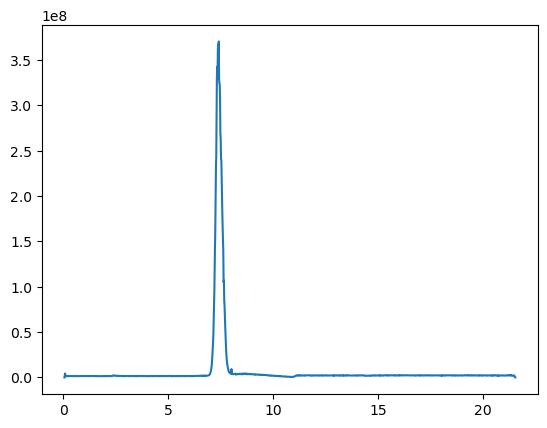

In [2]:
def get_chrom_mzmlb(file):
    scan_dfs = []
    for spectrum in mzmlb.MzMLb(file):
        if spectrum['ms level'] == 1:
            # print(spectrum["index"])
            mz_vals=spectrum['m/z array']
            int_vals = spectrum['intensity array']
            bet_mzs = mz_vals[abs(mz_vals-118.0865)<=0.001]
            bet_ints = int_vals[abs(mz_vals-118.0865)<=0.001]
            # print(bet_mzs)
            # print(bet_ints)
            rt_val = spectrum['scanList']['scan'][0]['scan start time']
            if(len(bet_mzs)>0):
                df_scan = pd.DataFrame({'mz':bet_mzs, 'int':bet_ints, 'rt':[rt_val]*len(bet_mzs)})
                scan_dfs.append(df_scan)    
    return(pd.concat(scan_dfs, ignore_index=True))

chrom_data = get_chrom_mzmlb('demo_data/180205_Poo_TruePoo_Full1.mzMLb')

plt.plot(chrom_data["rt"], chrom_data["int"])
plt.show()

<StemContainer object of 3 artists>

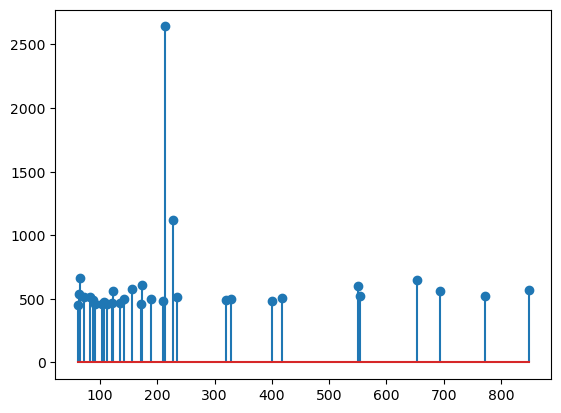

In [3]:
def get_spec_mzmlb_pyteomics(file, scan_num):
    file_data = mzmlb.MzMLb(file)
    return(pd.DataFrame({"mz":file_data[scan_num]['m/z array'], "int":file_data[scan_num]['intensity array']}))

spec_data = get_spec_mzmlb_pyteomics("demo_data/180205_Poo_TruePoo_Full1.mzMLb", 1)
plt.stem(spec_data["mz"], spec_data["int"])

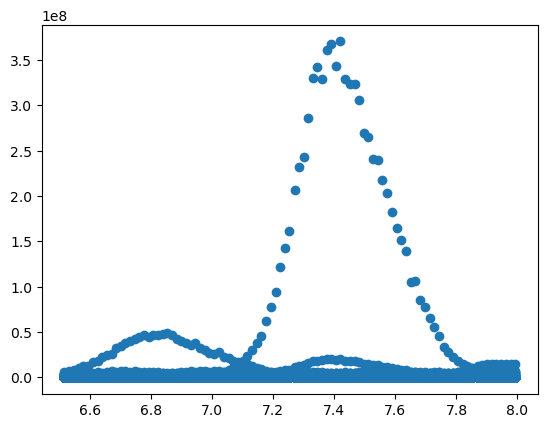

In [4]:
def get_rtrange_mzmlb_pyteomics(file, rtstart, rtend):
    scan_dfs = []
    for spectrum in mzmlb.MzMLb(file):
        rt_val = spectrum['scanList']['scan'][0]['scan start time']
        if(rtstart < rt_val < rtend):
            mz_vals=spectrum['m/z array']
            int_vals = spectrum['intensity array']
            df_scan = pd.DataFrame({'mz':mz_vals, 'int':int_vals, 'rt':[rt_val]*len(mz_vals)})
            scan_dfs.append(df_scan)    
    return(pd.concat(scan_dfs, ignore_index=True))

rtrange_data = get_rtrange_mzmlb_pyteomics('demo_data/180205_Poo_TruePoo_Full1.mzMLb', 6.5, 8)

plt.scatter(rtrange_data["rt"], rtrange_data["int"])
plt.show()

## Timing comparison to regular and indexed mzML

In [5]:
import mzsql

mzsql.get_spec_mzml_pyteomics("demo_data/180205_Poo_TruePoo_Full1.mzML", 1)
mzsql.get_spec_mzml_idx("demo_data/180205_Poo_TruePoo_Full1_idx.mzML", 3)
mzsql.get_spec_mzmlb("demo_data/180205_Poo_TruePoo_Full1.mzMLb", 1)
print("empty")

PyteomicsError: Pyteomics error, message: 'Positional access requires building an offset index.'

In [ ]:
import timeit
mzml_spec = timeit.repeat('mzsql.get_spec_mzml_pyteomics("demo_data/180205_Poo_TruePoo_Full1.mzML", 1)', globals=globals(), number=1, repeat=10)
mzml_idx_spec = timeit.repeat('mzsql.get_spec_mzml_idx("demo_data/180205_Poo_TruePoo_Full1_idx.mzML", 3)', globals=globals(), number=1, repeat=10)
mzmlb_spec = timeit.repeat('mzsql.get_spec_mzmlb("demo_data/180205_Poo_TruePoo_Full1.mzMLb", 1)', globals=globals(), number=1, repeat=10)

In [ ]:
plt.boxplot([mzml_spec, mzml_idx_spec, mzmlb_spec], tick_labels=["mzml", "idx_mzml", "mzmlb"])
plt.axhline(y=0, color="k")
plt.show()

## Chromatogram extraction

In [ ]:
mzsql.get_chrom_mzml_pyteomics("demo_data/180205_Poo_TruePoo_Full1.mzML", 118.0865, 10)
mzsql.get_chrom_mzml_idx("demo_data/180205_Poo_TruePoo_Full1_idx.mzML", 118.0865, 10)
mzsql.get_chrom_mzmlb("demo_data/180205_Poo_TruePoo_Full1.mzMLb", 118.0865, 10)
print("empty")

In [ ]:
mzml_chrom = timeit.repeat('mzsql.get_chrom_mzml_pyteomics("demo_data/180205_Poo_TruePoo_Full1.mzML", 118.0865, 10)', globals=globals(), number=1, repeat=10)
mzml_idx_chrom = timeit.repeat('mzsql.get_chrom_mzml_idx("demo_data/180205_Poo_TruePoo_Full1_idx.mzML", 118.0865, 10)', globals=globals(), number=1, repeat=10)
mzmlb_chrom = timeit.repeat('mzsql.get_chrom_mzmlb("demo_data/180205_Poo_TruePoo_Full1.mzMLb", 118.0865, 10)', globals=globals(), number=1, repeat=10)

In [ ]:
plt.boxplot([mzml_chrom, mzml_idx_chrom, mzmlb_chrom], tick_labels=["mzml", "idx_mzml", "mzmlb"])
plt.axhline(y=0, color="k")
plt.show()